<a href="https://colab.research.google.com/github/CaptainJimbo/MyPortfolio/blob/main/facesfacesfacesNOTcomplete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="left">
  <td align="left">
  <a target="_blank" href="https://sayhelloto.my.canva.site/dimitris-kogias" style="text-decoration: none; display: flex; align-items: center; color: white; background-color: purple; padding: 10px; border-radius: 5px;">
      <img src="https://static.wikia.nocookie.net/bravestarr/images/6/6d/Lucas_Conway.png/revision/latest?cb=20211111224054" width="40px" height="40px" style="border-radius: 50%; margin-right: 10px;" />
      <span>Visit my Website</span>
    </a>
  </td>
</table>



We will build a semi-supervised variational autoencoder (SS-VAE) that learns the latent distribution of features underlying face image datasets in order to uncover hidden biases.

In [37]:
import tensorflow as tf
import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


!pip install ipywidgets
import ipywidgets as widgets
from IPython.display import display, clear_output

!pip install mitdeeplearning
import mitdeeplearning as mdl

In [38]:
# Get the training data: both images from CelebA and ImageNet
# The function tf.keras.utils.get_file() is a utility provided
# by TensorFlow's Keras API to download a file from a URL if it isn't
# already in the cache. This can be useful for fetching datasets,
# model weights, or any other file necessary for an experiment.
# The function will look for the file in the cache directory first
#(by default, ~/.keras/), and if it doesn't find it, it will download it.
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [39]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(10000)

In [40]:
face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

In [41]:
def show(images,n=16):
    length = int(np.sqrt(n))
    plt.figure(figsize=(round(length*3/2),round(length*3/2)))
    random_inds = np.random.choice(len(images),n)
    for i in range(length**2):
        plt.subplot(length,length,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image_ind = random_inds[i]
        plt.imshow(images[image_ind])#, cmap=plt.cm.binary)
    plt.show()

In [42]:
def plot_images(idx_face, idx_not_face):
    plt.figure(figsize=(4,2))

    plt.subplot(1, 2, 1)
    plt.imshow(face_images[idx_face])
    plt.title("Face"); plt.grid(False); plt.xticks([]); plt.yticks([])

    plt.subplot(1, 2, 2)
    plt.imshow(not_face_images[idx_not_face])
    plt.title("Not Face"); plt.grid(False); plt.xticks([]); plt.yticks([])
    plt.show()

face_slider = widgets.IntSlider(min=0, max=50, step=1, value=2)
not_face_slider = widgets.IntSlider(min=0, max=50, step=1, value=8)
widgets.interactive(plot_images, idx_face=face_slider, idx_not_face=not_face_slider)

interactive(children=(IntSlider(value=2, description='idx_face', max=50), IntSlider(value=8, description='idx_…

Here are 100 images of faces. These images are used as positive examples. Keep in mind that already in this sample that is randomly picked the dark skinned
males and females are significantly less, which incorporates a bias (the classifier will identify less accurately dark skinned males and females). The classifier will use latent features to identify faces and not faces that have to do with bias.


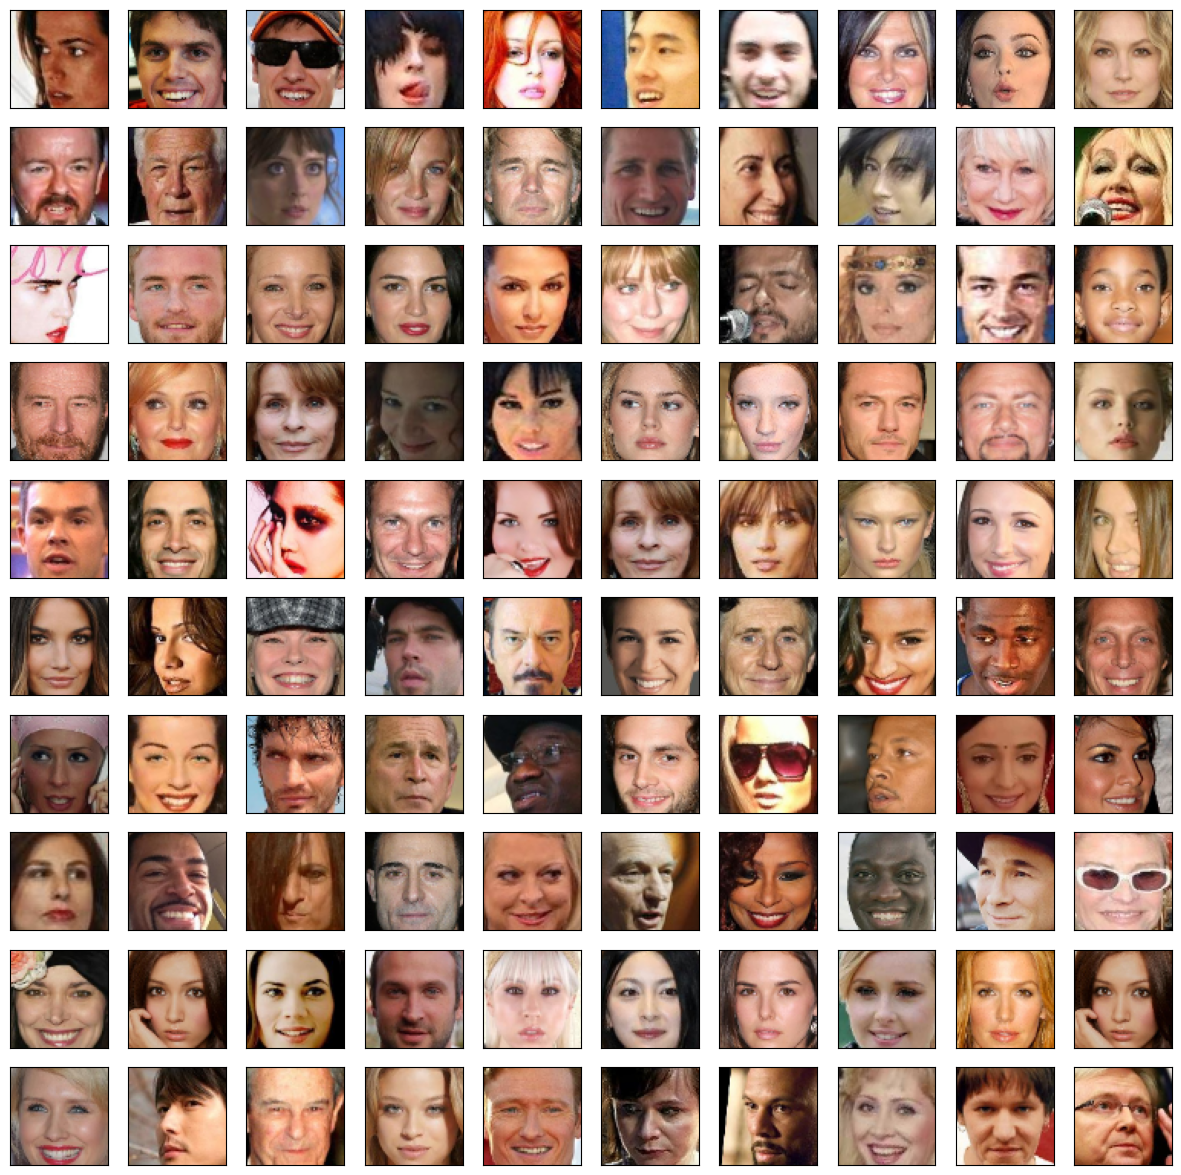

In [43]:
print('Here are 100 images of faces. These images are used as positive examples. Keep \
in mind that already in this sample that is randomly picked the dark skinned\nmales and females \
are significantly less, which incorporates a bias (the classifier will identify less accurately dark skinned \
males and females). The classifier will use latent features to identify faces and not faces that have to do with bias.')
show(face_images,100)


Here are 16 images of not faces. These images are used as negative examples.


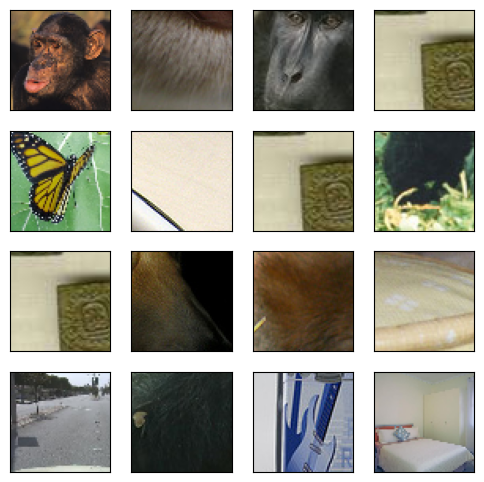

In [44]:
print('Here are 16 images of not faces. These images are used as negative examples.')
show(not_faces,16)

We will set up and train a basic CNN to identify if a specific image depicts a face or doesn't. After training, we'll assess its performance. The architecture of a CNN follows a typical pattern, with several convolutional layers with batch normalization followed by two fully connected layers to flatten the convolution output and generate a class prediction.

In [45]:
def standard_CNN(n_outputs=1):
    Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

    model = tf.keras.Sequential([
    #1st layer
    Conv2D(filters=1*12, kernel_size=5,  strides=2),
    BatchNormalization(),
    #2nd layer
    Conv2D(filters=2*12, kernel_size=5,  strides=2),
    BatchNormalization(),
    #3rd layer
    Conv2D(filters=4*12, kernel_size=3,  strides=2),
    BatchNormalization(),
    #4th layer
    Conv2D(filters=6*12, kernel_size=3,  strides=2),
    BatchNormalization(),
    #5th layer
    Flatten(),
    #6th layer
    Dense(512),
    #7th layer
    Dense(n_outputs, activation=None),
    ])

    return model

standard_classifier = standard_CNN()

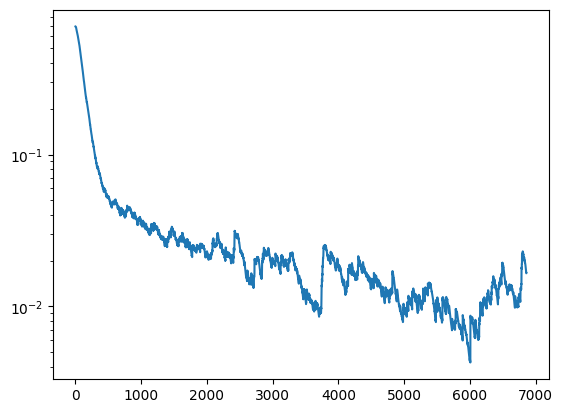

100%|██████████| 3434/3434 [05:15<00:00, 10.88it/s]


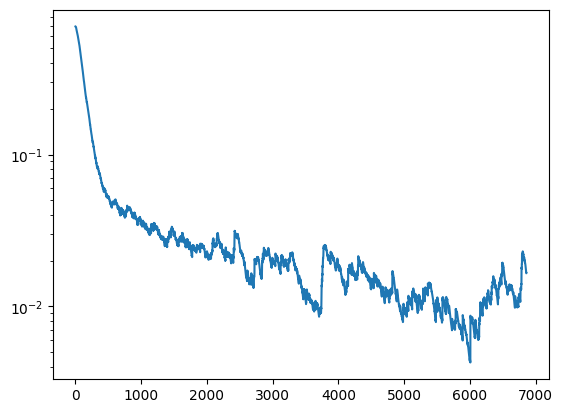

In [46]:
batch_size = 32
num_epochs = 2
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = standard_classifier(x)
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

# The training loop!
for epoch in range(num_epochs):
  for idx in tqdm(range(loader.get_train_size()//batch_size)):
    # Grab a batch of training data and propagate through the network
    x, y = loader.get_batch(batch_size)
    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

In [47]:
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
# tf.equal() compares
# tf.cast() transform to type
# tf.reduce_mean() find the average
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

157/157 [==============================] - 12s 66ms/step
Standard CNN accuracy on (potentially biased) training set: 0.9974
